In [1]:
import matplotlib.pyplot as plt
import scienceplots


import numpy as np
import scipy.stats
import pandas as pd

import datetime

import sqlalchemy as sqla

from pathlib import Path

In [2]:
plt.style.use(['science','no-latex'])

In [10]:
dtypes={'trilha': 'object', 'nivel': np.int32, 
           'prob_conclusao': np.float64, 'prob_continuar':np.float64}
df_prob = pd.DataFrame(np.array([
    ['Facil', 1, 0.97, 0.99],
    ['Facil', 2, 0.97, 0.99],
    ['Facil', 3, 0.95, 0.99],
    ['Facil', 4, 0.95, 0.99],
    ['Facil', 5, 0.93, 0.99],
    ['Medio', 1, 0.97, 0.99],
    ['Medio', 2, 0.97, 0.99],
    ['Medio', 3, 0.95, 0.99],
    ['Medio', 4, 0.95, 0.99],
    ['Medio', 5, 0.93, 0.99],
    ['Medio', 6, 0.90, 0.99],
    ['Medio', 7, 0.90, 0.99],
    ['Medio', 8, 0.85, 0.99],
    ['Dificil', 1, 0.97, 0.99],
    ['Dificil', 2, 0.97, 0.99],
    ['Dificil', 3, 0.95, 0.99],
    ['Dificil', 4, 0.95, 0.99],
    ['Dificil', 5, 0.93, 0.99],
    ['Dificil', 6, 0.90, 0.99],
    ['Dificil', 7, 0.90, 0.99],
    ['Dificil', 8, 0.85, 0.99], 
    ['Dificil', 9, 0.85, 0.99], 
    ['Dificil', 10, 0.80, 0.99], 
    ['Dificil', 11, 0.80, 0.99], 
    ['Dificil', 12, 0.77, 0.99], 
    ['Dificil', 13, 0.70, 0.99]
]), columns=['trilha','nivel','prob_conclusao','prob_continuar'])
df_prob = df_prob.astype(dtype=dtypes).set_index(['trilha','nivel'])



In [43]:
def limpa_arquivo(arquivo):
    if arquivo.exists(): arquivo.unlink()

def salva_arquivos(dia, header, arquivo_sessao, arquivo_eventos):
    # Gera dados de sessao_jogador
    arr=[]
    for i in range(ids_sessoes.size):
        id_sessao = ids_sessoes[i]
        id_jogador = ids_jogadores_sessoes[i]
        so_sessao = so_sessoes[i]
        trilha = trilhas[i]
        versao_jogo = versoes[i]
        ts_criacao = dia + datetime.timedelta(seconds=horarios[i])
        arr.append([id_sessao, id_jogador, so_sessao, trilha, ts_criacao, versao_jogo])
    
    df_sessoes = pd.DataFrame(arr, columns=['id_sessao','id_jogador','so_sessao','trilha','ts_criacao','versao_jogo'])
    df_sessoes.to_csv(path_or_buf=arquivo_sessao, header=header, index=False, mode='a')
    
    # Gera dados de eventos para cada sessao
    arr = []
    dist_tempo_nivel = scipy.stats.norm(loc=60,scale=10)
    for index, row in df_sessoes.reset_index().iterrows():
        # if index > 2: break
        id_sessao = row['id_sessao']
        trilha = row['trilha']
        ts_evento = row['ts_criacao']
        for nivel, (p_concluir, p_continuar) in df_prob.loc[trilha,:].iterrows():
            # print(id_sessao, trilha, nivel, ts_evento, 'I')
            arr.append([id_sessao, ts_evento, nivel, 'I'])
            if np.random.random_sample() < p_concluir:
                ts_evento += + datetime.timedelta(seconds=dist_tempo_nivel.rvs())
                # print(id_sessao, trilha, nivel, ts_evento, 'F')
                arr.append([id_sessao, ts_evento, nivel, 'F'])
            if np.random.random_sample() < (1-p_continuar):
                break
            ts_evento += + datetime.timedelta(seconds=10)
    
    df_eventos = pd.DataFrame(arr, columns=['id_sessao','ts_evento','nivel','indicador'])
    df_eventos.to_csv(arquivo_eventos, mode='a', index=False, header=header)
    

In [101]:
dist_max_sess_dia_util = scipy.stats.norm(5000, 100)
dist_max_sess_fim_semana = scipy.stats.norm(8000, 500)
dist_inicio_sessao = scipy.stats.norm(43200,7200)
dist_tempo_nivel = scipy.stats.norm(loc=60,scale=10)

lista_dias = pd.date_range('2025-02-03', '2025-03-09', freq='1D')

def cria_sessoes(dia: pd.Timestamp, id_sessao_anterior, arquivo_sessao, arquivo_eventos, header):
    # Gera dados de sessao_jogador
    if dia.weekday() in (5,6):
        #Fim de semana. Crie mais sessões
        max_sessoes_criadas = np.int32(dist_max_sess_fim_semana.rvs())
    else:
        #Dia de semana. Crie menos sessões
        max_sessoes_criadas = np.int32(dist_max_sess_dia_util.rvs())

    file_sessoes = arquivo_sessao.open(mode='a')
    file_eventos = arquivo_eventos.open(mode='a')
    
    if header==True:
        file_sessoes.write("id_sessao,id_jogador,so_sessao,trilha,ts_criacao,versao_jogo\n")
        file_eventos.write("id_sessao,ts_evento,nivel,indicador_conclusao\n")
    
    for id_sessao in range(id_sessao_anterior+1, id_sessao_anterior+1+max_sessoes_criadas):
        
        id_jogador = np.random.choice(ids_jogadores)
        so_sessao = np.random.choice(['Windows', 'Mac', 'Linux'], p=[0.7, .25, .05])
        trilha = np.random.choice(['Facil', 'Medio', 'Dificil'], p=[0.5, .3, .2])
        versao_jogo = np.random.choice(['1.5.3', '2.1.9'], p=[0.9, .1])
        ts_criacao = dia + datetime.timedelta(seconds=dist_inicio_sessao.rvs())

        file_sessoes.write(f"{id_sessao},{id_jogador},{so_sessao},{trilha},{ts_criacao},{versao_jogo}\n")
        
        cria_eventos(id_sessao, ts_criacao, trilha, file_eventos)
        
    return id_sessao_anterior+max_sessoes_criadas

def cria_eventos(id_sessao, ts_criacao, trilha, file_eventos):
    ts_evento = ts_criacao
    for nivel, (p_concluir, p_continuar) in df_prob.loc[trilha,:].iterrows():
        file_eventos.write(f"{id_sessao},{ts_evento},{nivel},I\n")
        if np.random.random_sample() < p_concluir:
            ts_evento += + datetime.timedelta(seconds=dist_tempo_nivel.rvs())
            file_eventos.write(f"{id_sessao},{ts_evento},{nivel},F\n")
        if np.random.random_sample() < (1-p_continuar):
            break
        ts_evento += + datetime.timedelta(seconds=10)    


In [106]:
%%time

arquivo_sessao=Path("../data/sessao_jogador.csv")
arquivo_eventos=Path("../data/eventos_sessao.csv")
if arquivo_sessao.exists(): arquivo_sessao.unlink()
if arquivo_eventos.exists(): arquivo_eventos.unlink()

for i, dia in enumerate(lista_dias):
    # print(i, dia)
    if i==0:
        header = True
        ultima_id_sessao = 0
    else:
        header = False
    ultima_id_sessao = cria_sessoes(dia, ultima_id_sessao, arquivo_sessao, arquivo_eventos, header=True)
    print(header, dia, ultima_id_sessao)

# ultima_id_sessao = cria_sessoes(dia1, 0, arquivo_sessao, arquivo_eventos, header=True)
# cria_sessoes(dia2,ultima_id_sessao,arquivo_sessao, arquivo_eventos, header=False)


True 2025-02-03 00:00:00 4968
False 2025-02-04 00:00:00 9788
False 2025-02-05 00:00:00 14851
False 2025-02-06 00:00:00 19944
False 2025-02-07 00:00:00 25017
False 2025-02-08 00:00:00 33259
False 2025-02-09 00:00:00 40016
False 2025-02-10 00:00:00 44972
False 2025-02-11 00:00:00 49949
False 2025-02-12 00:00:00 54970
False 2025-02-13 00:00:00 60072
False 2025-02-14 00:00:00 65013
False 2025-02-15 00:00:00 73008
False 2025-02-16 00:00:00 80109
False 2025-02-17 00:00:00 85200
False 2025-02-18 00:00:00 90383
False 2025-02-19 00:00:00 95304
False 2025-02-20 00:00:00 100353
False 2025-02-21 00:00:00 105336
False 2025-02-22 00:00:00 112451
False 2025-02-23 00:00:00 120551
False 2025-02-24 00:00:00 125542
False 2025-02-25 00:00:00 130584
False 2025-02-26 00:00:00 135673
False 2025-02-27 00:00:00 140772
False 2025-02-28 00:00:00 145785
False 2025-03-01 00:00:00 153083
False 2025-03-02 00:00:00 161188
False 2025-03-03 00:00:00 166170
False 2025-03-04 00:00:00 171399
False 2025-03-05 00:00:00 1764

In [116]:
pd.to_datetime(df['ts_criacao'])
# df['ts_criacao']

0        2025-02-03 12:13:17.358419
1        2025-02-03 12:29:49.578749
2        2025-02-03 10:53:56.952750
3        2025-02-03 12:25:24.308979
4        2025-02-03 12:38:16.234452
                    ...            
202856   2025-03-09 09:20:59.054545
202857   2025-03-09 12:11:58.499045
202858   2025-03-09 14:45:30.933285
202859   2025-03-09 13:02:55.337310
202860   2025-03-09 13:10:11.139586
Name: ts_criacao, Length: 202861, dtype: datetime64[ns]

In [119]:
df.astype({'ts_criacao':'datetime64[ns]', 'id_sessao':'int32','id_jogador':'int32'}).dtypes

id_sessao               int32
id_jogador              int32
so_sessao              object
trilha                 object
ts_criacao     datetime64[ns]
versao_jogo            object
dtype: object

In [122]:
df = pd.read_csv("../data/sessao_jogador.csv")
df = df.astype({'ts_criacao':'datetime64[ns]', 'id_sessao':'int32','id_jogador':'int32'})
# df['ts_criacao'] = pd.to_datetime(df['ts_criacao'])

In [131]:
!pwd

/home/vinicius/Vinicius/Desenvolvimento/workshop-gecap2-25/nb


In [134]:
workshop_db_engine = sqla.create_engine("sqlite:///../db/workshop.db")


Index(['id_sessao', 'id_jogador', 'so_sessao', 'trilha', 'ts_criacao',
       'versao_jogo'],
      dtype='object')

In [141]:
df.to_sql('sessao_jogador',workshop_db_engine, if_exists='append', index=False)


202861

In [144]:
df = pd.read_csv("../data/eventos_sessao.csv")
df = df.astype({'ts_evento':'datetime64[ns]', 'id_sessao':'int32','nivel':'int32'})

In [146]:
df.to_sql('eventos_sessao',workshop_db_engine, if_exists='append', index=False)

2809886

# Carrega dfs

In [226]:
workshop_db_engine = sqla.create_engine("sqlite:///../db/workshop.db")

In [270]:
# df_sj_base = (pd.read_sql('sessao_jogador', workshop_db_engine)
#                 .astype({'ts_criacao':'datetime64[ns]'})
#              )

df_es_base = (pd.read_sql("""SELECT es.* FROM eventos_sessao es where date(es.ts_evento ) = '2025-02-11'""", workshop_db_engine)
                .astype({'ts_evento':'datetime64[ns]'})
             ).set_index(['id_sessao'])

In [271]:
df_es_base.ts_evento = (df_es_base[(df_es_base.ts_evento > '2025-02-11 12:00:00') & (df_es_base.ts_evento < '2025-02-11 14:00:00')].ts_evento + datetime.timedelta(hours=2))


ValueError: cannot reindex on an axis with duplicate labels

In [267]:
df_es_base

id_sessao
44973   2025-02-11 14:25:26.425633
44973   2025-02-11 14:26:31.052557
44973   2025-02-11 14:26:41.052557
44973   2025-02-11 14:27:27.882632
44973   2025-02-11 14:27:37.882632
                   ...            
49946   2025-02-11 15:04:45.444752
49946   2025-02-11 15:04:55.444752
49946   2025-02-11 15:05:49.309080
49946   2025-02-11 15:05:59.309080
49946   2025-02-11 15:06:45.794174
Name: ts_evento, Length: 23694, dtype: datetime64[ns]

In [255]:
df_crise_a = df_es_base.loc[:, '2025-02-11 12:00:00':'2025-02-11 14:00:00',:].copy()
# df_es_base.loc[:, '2025-02-11 12:00:00':'2025-02-11 14:00:00',:]

In [212]:
df.loc['2025-02-11 14:30:00'] = df.loc['2025-02-11 14:30:00'].values + (df_crise_a.groupby(level=[1]).sum().astype('float64')*0.5).values

/tmp/ipykernel_9959/4096812832.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2352.5 2329.  2273.5 2263.  2217.  1126.5 1116.5 1091.   420.5  400.5
  398.5  391.5  378. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc['2025-02-11 14:30:00'] = df.loc['2025-02-11 14:30:00'].values + (df_crise_a.groupby(level=[1]).sum().astype('float64')*0.5).values


In [213]:
df.loc['2025-02-11 14:30:00']

,ctg
nivel,
1,2352.5
2,2329.0
3,2273.5
4,2263.0
5,2217.0
6,1126.5
7,1116.5
8,1091.0
9,420.5


[]

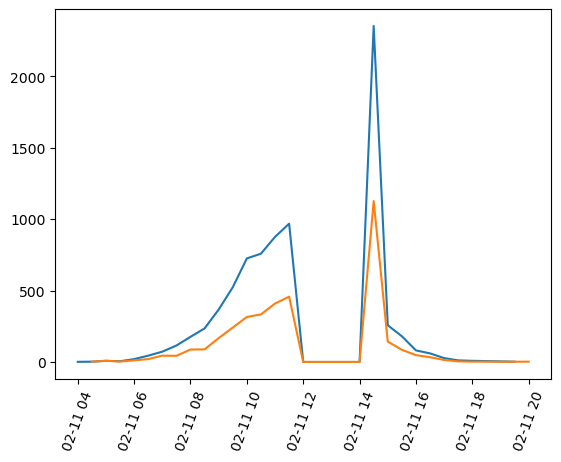

In [214]:
fig, ax = plt.subplots()
ax.plot(df.loc['2025-02-11',1])
ax.plot(df.loc['2025-02-11',6])
plt.xticks(rotation=70)
plt.plot()

# Gráficos

In [313]:
df2=df.groupby([
    df['ts_criacao'].dt.floor('30min'),
    df['so_sessao'],
    df['trilha'],
    df['versao_jogo']
]).count()


<Axes: xlabel='ts_criacao'>

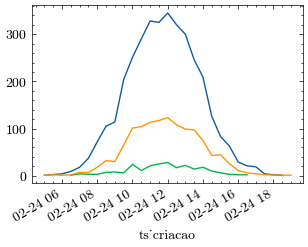

In [332]:
df2.loc[:,'Windows',:,:]['id_sessao'].groupby(axis=0, level=[0]).sum().plot()
df2.loc[:,'Linux',:,:]['id_sessao'].groupby(axis=0, level=[0]).sum().plot()
df2.loc[:,'Mac',:,:]['id_sessao'].groupby(axis=0, level=[0]).sum().plot()
# df2.loc[:,'Windows','Medio','2.1.0']['id_sessao'].plot()
# df2.loc[:,'Windows','Dificil','2.1.0']['id_sessao'].plot()
# plt.legend()